In [1]:
%cd ..

/home/romet/projects/ut/e2e-rally-estonia


In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision

from dataloading.nvidia import NvidiaDataset, NvidiaValidationDataset, Normalize
from pilotnet import PilotnetControl, PilotNetConditional
from metrics.metrics import calculate_open_loop_metrics
from viz.analytics import create_waypoint_error_plot

from metrics.metrics import calculate_trajectory_open_loop_metrics, calculate_open_loop_metrics
from trajectory import calculate_steering_angle
import math

from trainer import ControlTrainer, ConditionalTrainer
from torchvision import transforms

from camera_frame import CameraFrameTransformer


%load_ext autoreload 
%autoreload 2


import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from metrics.metrics import calculate_lateral_errors, read_frames_driving


In [482]:
def draw_error_plot_ax(ax, model_ds, expert_ds, title=None, draw_road=True, intervention_types=None, draw_legend=False):
    #lat_errors = calculate_lateral_errors(model_ds.frames, expert_ds.frames, only_autonomous=True)
    positions_df = model_ds.frames
    
    #autonomous_df = positions_df[positions_df.autonomous].reset_index(drop=True)
    if draw_road:
        ax.scatter(positions_df["position_x"], positions_df["position_y"],
                   s=1,
                   marker='.',
                   c="lightgray", cmap=plt.cm.coolwarm)

    #manual_df = positions_df[positions_df.autonomous == False].reset_index(drop=True)
    #ax.scatter(manual_df["position_x"], manual_df["position_y"],
    #            s=5,
    #            c="#2BFA00")
    
    positions_df['autonomous_next'] = positions_df.shift(-1)['autonomous']
    interventions_df = positions_df[positions_df.autonomous & (positions_df.autonomous_next == False)]
    if intervention_types:
        interventions_df["type"] = intervention_types
    else:
        interventions_df["type"] = Intervention.CURB.value
        
    #print(interventions_df)
    
    intervention_groups = interventions_df.groupby('type')
    for intervention_type, intervention in intervention_groups:
        if intervention_type is not Intervention.EXCLUDED.value:
            ax.scatter(intervention["position_x"], intervention["position_y"],
                        s=60,
                       alpha=alpha,
                       marker='o',
                       color=color_map[intervention_type],
                        label=intervention_type)

    if title:
        ax.set_title(title)
    
    if draw_legend:
        ax.legend(loc="lower left")

In [361]:
def draw_error_plot(model_ds, expert_ds, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    draw_error_plot_ax(ax, model_ds, expert_ds, title)

In [362]:
from enum import Enum

class Intervention(Enum):
    SIDE_ROAD = "sideroad"
    CROSSROAD = "crossroad"
    CURB = "curb"
    OFF = "off"
    EXCLUDED = "excluded"

In [363]:
def load_dataset(paths):
        return NvidiaDataset(paths,
                             transform=tr,
                             output_modality="steering_angle", 
                             metadata_file="nvidia_frames.csv")

In [364]:
color_map.values()

dict_values([(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0), (0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0), (0.596078431372549, 0.3058823529411765, 0.6392156862745098, 1.0), (1.0, 0.4980392156862745, 0.0, 1.0)])

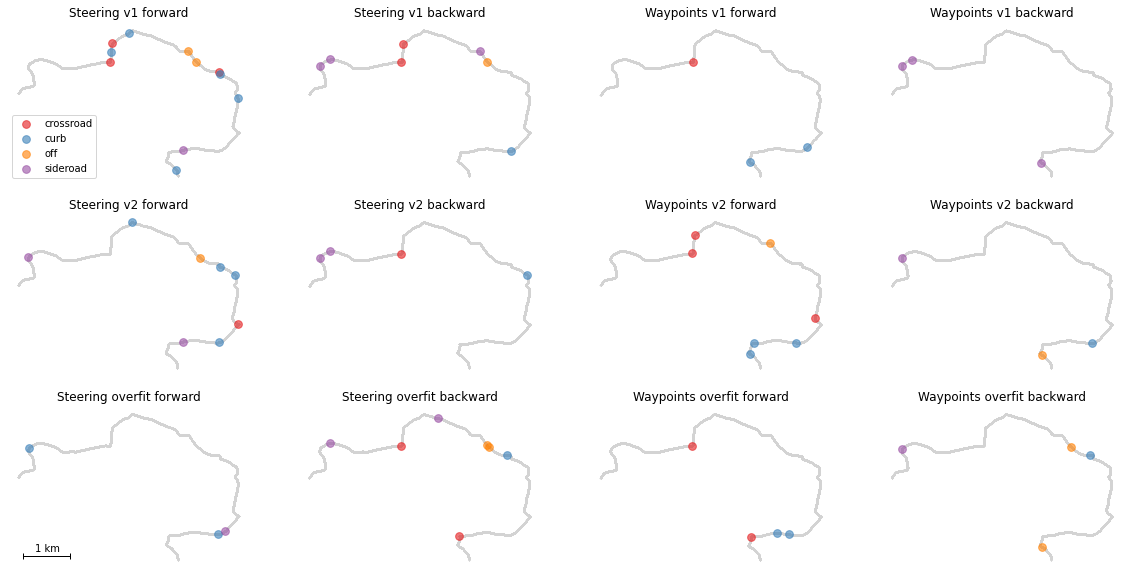

In [488]:
fig, ax = plt.subplots(3, 4, figsize=(20, 10))

[axi.set_axis_off() for axi in ax.ravel()]

steering_1_forw_int = [ 
                        Intervention.CURB.value,
                        Intervention.SIDE_ROAD.value,
                        Intervention.EXCLUDED.value,
                        Intervention.EXCLUDED.value,
                        Intervention.CURB.value,
                        Intervention.CURB.value,
                        Intervention.CROSSROAD.value,
                        Intervention.EXCLUDED.value,
                        Intervention.OFF.value,
                        Intervention.OFF.value,
                        Intervention.CURB.value,
                        Intervention.EXCLUDED.value,
                        Intervention.CROSSROAD.value,
                        Intervention.CURB.value,
                        Intervention.CROSSROAD.value
                        ]
draw_error_plot_ax(ax[0, 0], steering_1_forward, expert_dataset, f"Steering v1 forward",
                  intervention_types=steering_1_forw_int, draw_legend=True)

steering_1_backw_int = [ 
                        Intervention.EXCLUDED.value,
                        Intervention.SIDE_ROAD.value,
                        Intervention.SIDE_ROAD.value,
                        Intervention.CROSSROAD.value,
                        Intervention.CROSSROAD.value,
                        Intervention.EXCLUDED.value,
                        Intervention.EXCLUDED.value,
                        Intervention.SIDE_ROAD.value,
                        Intervention.OFF.value,
                        Intervention.EXCLUDED.value,
                        Intervention.EXCLUDED.value,
                        Intervention.CURB.value
                        ]
draw_error_plot_ax(ax[0, 1], steering_1_backward, expert_dataset, f"Steering v1 backward",
                  intervention_types=steering_1_backw_int)

steering_2_forw_int = [Intervention.SIDE_ROAD.value,
                        Intervention.CURB.value,
                        Intervention.EXCLUDED.value,
                        Intervention.CROSSROAD.value,
                        Intervention.CURB.value,
                        Intervention.CURB.value,
                        Intervention.EXCLUDED.value,
                        Intervention.OFF.value,
                        Intervention.EXCLUDED.value,
                        Intervention.CURB.value,
                        Intervention.EXCLUDED.value,
                        Intervention.EXCLUDED.value,
                        Intervention.SIDE_ROAD.value,
                        Intervention.EXCLUDED.value
                        ]
draw_error_plot_ax(ax[1, 0], steering_2_forward, expert_dataset, f"Steering v2 forward",
                  intervention_types=steering_2_forw_int)

steering_2_backw_int = [Intervention.EXCLUDED.value,
                        Intervention.EXCLUDED.value,
                        Intervention.EXCLUDED.value,
                        Intervention.SIDE_ROAD.value,
                        Intervention.SIDE_ROAD.value,
                        Intervention.CROSSROAD.value,
                        Intervention.EXCLUDED.value,
                        Intervention.EXCLUDED.value,
                        Intervention.CURB.value,
                        Intervention.EXCLUDED.value,
                        Intervention.EXCLUDED.value,
                        Intervention.EXCLUDED.value,
                        Intervention.EXCLUDED.value,
                        ]
draw_error_plot_ax(ax[1, 1], steering_2_backward, expert_dataset, f"Steering v2 backward",
                  intervention_types=steering_2_backw_int)

steering_overfit_forw_int = [Intervention.CURB.value, 
                             Intervention.SIDE_ROAD.value, 
                             Intervention.CURB.value]
draw_error_plot_ax(ax[2, 0], steering_overfit_forward, expert_dataset, f"Steering overfit forward", 
                   intervention_types=steering_overfit_forw_int)

steering_overfit_backw_int = [Intervention.EXCLUDED.value, 
                              Intervention.SIDE_ROAD.value, 
                              Intervention.CROSSROAD.value,
                              Intervention.SIDE_ROAD.value,
                              Intervention.OFF.value,
                              Intervention.OFF.value,
                              Intervention.CURB.value,
                              Intervention.EXCLUDED.value,
                              Intervention.CROSSROAD.value,
                              Intervention.EXCLUDED.value,
                              Intervention.EXCLUDED.value
                             ]
draw_error_plot_ax(ax[2, 1], steering_overfit_backward, expert_dataset, f"Steering overfit backward",
                  intervention_types=steering_overfit_backw_int)

waypoints_1_forw_int = [Intervention.CURB.value, 
                              Intervention.CURB.value, 
                              Intervention.CROSSROAD.value,
                              Intervention.EXCLUDED.value
                             ]
draw_error_plot_ax(ax[0, 2], waypoints_1_forward, expert_dataset, f"Waypoints v1 forward",
                  intervention_types=waypoints_1_forw_int)

waypoints_1_backw_int = [Intervention.EXCLUDED.value,
                         Intervention.SIDE_ROAD.value, 
                         Intervention.SIDE_ROAD.value,
                         Intervention.EXCLUDED.value,
                         Intervention.EXCLUDED.value,
                         Intervention.EXCLUDED.value,
                         Intervention.SIDE_ROAD.value,
                        ]

draw_error_plot_ax(ax[0, 3], waypoints_1_backward, expert_dataset, f"Waypoints v1 backward",
                  intervention_types=waypoints_1_backw_int)

waypoints_2_forw_int = [Intervention.CURB.value,
                        Intervention.CURB.value, 
                        Intervention.CURB.value,
                        Intervention.CROSSROAD.value,
                        Intervention.OFF.value,
                        Intervention.EXCLUDED.value,
                        Intervention.EXCLUDED.value,
                        Intervention.EXCLUDED.value,
                        Intervention.CROSSROAD.value,
                        Intervention.CROSSROAD.value,
                        Intervention.EXCLUDED.value
                        ]
draw_error_plot_ax(ax[1, 2], waypoints_2_forward, expert_dataset, f"Waypoints v2 forward",
                  intervention_types=waypoints_2_forw_int)

waypoints_2_backw_int = [Intervention.SIDE_ROAD.value,
                        Intervention.EXCLUDED.value, 
                        Intervention.EXCLUDED.value,
                        Intervention.EXCLUDED.value,
                        Intervention.EXCLUDED.value,
                        Intervention.CURB.value,
                        Intervention.OFF.value
                        ]
draw_error_plot_ax(ax[1, 3], waypoints_2_backward, expert_dataset, f"Waypoints v2 backward",
                  intervention_types=waypoints_2_backw_int)

waypoints_overfit_forw_int = [Intervention.CROSSROAD.value,
                              Intervention.CURB.value, 
                              Intervention.CURB.value,
                              Intervention.EXCLUDED.value,
                              Intervention.EXCLUDED.value,
                              Intervention.CROSSROAD.value,
                              Intervention.EXCLUDED.value
                             ]
draw_error_plot_ax(ax[2, 2], waypoints_overfit_forward, expert_dataset, f"Waypoints overfit forward",
                  intervention_types=waypoints_overfit_forw_int)

waypoints_overfit_backw = [Intervention.SIDE_ROAD.value,
                              Intervention.OFF.value, 
                              Intervention.CURB.value,
                              Intervention.EXCLUDED.value,
                              Intervention.EXCLUDED.value,
                              Intervention.OFF.value
                             ]
draw_error_plot_ax(ax[2, 3], waypoints_overfit_backward, expert_dataset, f"Waypoints overfit backward",
                   intervention_types=waypoints_overfit_backw)

# add map scale to bottom left\n"
x_min = steering_2_forward.frames["position_y"].min()
y_min = steering_2_forward.frames["position_x"].min()
p1, p2 = [y_min+100, y_min+1000], [x_min+100, x_min+100],
ax[2, 0].plot(p1, p2, marker = '|', color="black", linewidth=1)
ax[2, 0].text(y_min+330, x_min+200, "1 km")

fig.savefig('drives.png', dpi=300)

In [450]:
steering_interventions = []
steering_interventions.extend(steering_1_forw_int)
steering_interventions.extend(steering_1_backw_int)
steering_interventions.extend(steering_2_forw_int)
steering_interventions.extend(steering_2_backw_int)
steering_interventions.extend(steering_overfit_forw_int)
steering_interventions.extend(steering_overfit_backw_int)
steering_df = pd.DataFrame({"intervention": steering_interventions})

waypoints_interventions = []
waypoints_interventions.extend(waypoints_1_forw_int)
waypoints_interventions.extend(waypoints_1_backw_int)
waypoints_interventions.extend(waypoints_2_forw_int)
waypoints_interventions.extend(waypoints_2_backw_int)
waypoints_interventions.extend(waypoints_overfit_forw_int)
waypoints_interventions.extend(waypoints_overfit_backw)
waypoints_df = pd.DataFrame({"intervention": waypoints_interventions})

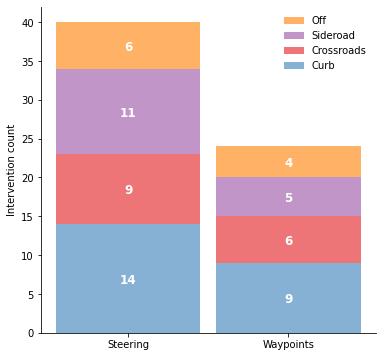

In [537]:
labels = ["Steering", "Waypoints"]
steering_counts = steering_df.groupby(["intervention"])["intervention"].count()
waypoints_counts = waypoints_df.groupby(["intervention"])["intervention"].count()

cross_road_counts = np.array([steering_counts["crossroad"], waypoints_counts["crossroad"]])
curb_counts = np.array([steering_counts["curb"], waypoints_counts["curb"]])
sideroad_counts = np.array([steering_counts["sideroad"], waypoints_counts["sideroad"]])
off_counts = np.array([steering_counts["off"], waypoints_counts["off"]])

fig, ax = plt.subplots(figsize=(6, 6))

bar_width = 0.9
alpha = 0.6
ax.bar(labels, curb_counts, bar_width, label='Curb', color=color_map["curb"], alpha=alpha)
ax.bar(labels, cross_road_counts, bar_width, label='Crossroads', bottom=curb_counts, color=color_map["crossroad"], alpha=alpha)
ax.bar(labels, sideroad_counts,  bar_width, bottom=cross_road_counts+curb_counts, label='Sideroad', color=color_map["sideroad"], alpha=alpha)
ax.bar(labels, off_counts,  bar_width, bottom=cross_road_counts+curb_counts+sideroad_counts, label='Off', color=color_map["off"], alpha=alpha)

# https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/
#
# Let's put the annotations inside the bars themselves by using a
# negative offset.
y_offset = -2
# For each patch (basically each rectangle within the bar), add a label.
for bar in ax.patches:
    ax.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
      bar.get_x() + bar.get_width() / 2,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
      #bar.get_height() + bar.get_y() + y_offset,
      (bar.get_y() + bar.get_height() / 2)-0.6,
      # This is actual value we'll show.
      round(bar.get_height()),
      # Center the labels and style them a bit.
      ha='center',
      color='w',
      weight='bold',
      size=12
    )
    
#ax.text(0, 40 + 0.8, 40, ha='center', size=12)
#ax.text(1, 24 + 0.8, 24, ha='center', size=12)

ax.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), frameon=False)

ax.set_ylabel('Intervention count')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
fig.savefig('interventions.png', dpi=300)

In [325]:
colors = [plt.cm.Set1(i/float(len(vals)-1)) for i in range(7)]
color_map = {
    "crossroad": colors[0],
    "curb": colors[1],
    "sideroad": colors[2],
    "off": colors[3]}
    

In [445]:
cross_road_counts

array([9, 6])

In [446]:
curb_counts

array([14,  9])

In [447]:
sideroad_counts

array([11,  5])

In [448]:
off_counts

array([6, 4])

In [449]:
steering_interventions.extend(steering_1_forw_int)
steering_interventions.extend(steering_1_backw_int)
steering_interventions.extend(steering_2_forw_int)
steering_interventions.extend(steering_2_backw_int)
steering_interventions.extend(steering_overfit_forw_int)
steering_interventions.extend(steering_overfit_backw_int)

In [462]:
len([x for x in steering_1_forw_int if x is not 'excluded'])

11

In [463]:
len([x for x in steering_1_backw_int if x is not 'excluded'])

7

In [464]:
len([x for x in steering_2_forw_int if x is not 'excluded'])

8

In [465]:
len([x for x in steering_2_backw_int if x is not 'excluded'])

4

In [466]:
len([x for x in steering_overfit_forw_int if x is not 'excluded'])

3

In [467]:
len([x for x in steering_overfit_backw_int if x is not 'excluded'])

7

In [459]:
steering_overfit_backw_int

['excluded',
 'sideroad',
 'crossroad',
 'sideroad',
 'off',
 'off',
 'curb',
 'excluded',
 'crossroad',
 'excluded',
 'excluded']